In [3]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


### Let's take the square as a bijector

z -- f(z)=z^2 --> x

In [5]:
f = tfb.Square() # This is a bijector
f.forward(2.0) #4
f.inverse(4.0) #2

<tf.Tensor: id=3, shape=(), dtype=float32, numpy=2.0>

Let's use the uniform distribution as a base transformation 

In [6]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=f)

In [7]:
mydist.prob(3)

<tf.Tensor: id=50, shape=(), dtype=float32, numpy=0.14433756>

(0, 1)

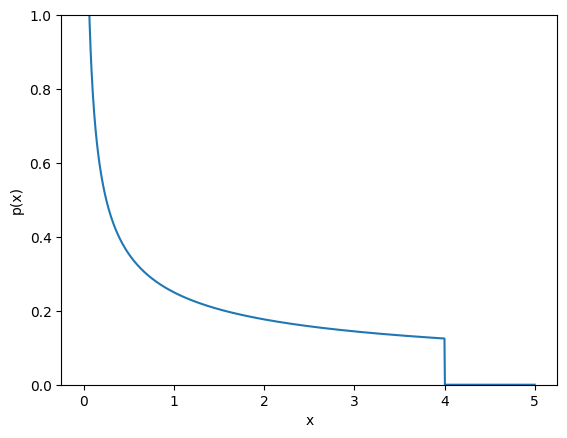

In [8]:
xs = np.linspace(0.001, 5,1000)
ps = mydist.prob(xs)
plt.plot(xs,ps)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

### Using several bijectors

In [9]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: id=118, shape=(), dtype=float32, numpy=16.0>

### Train a flow

This example is taken from: https://blog.evjang.com/2018/01/nf1.html?m=1. 

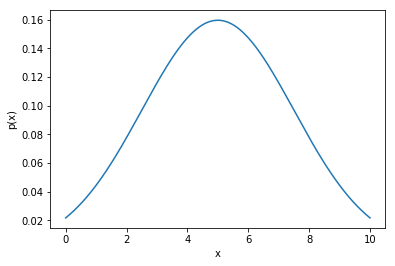

In [7]:
data_dist =  tfd.Normal(5,2.5)
# data_dist = tfd.Mixture(
#           cat=tfd.Categorical(probs=(0.3,0.7)),
#           components=[
#             tfd.Normal(3,0.3), 
#             tfd.Normal(5,0.3),  
#         ])

xs = np.linspace(0,10,500)
ys = data_dist.prob(xs)
plt.plot(xs,ys)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

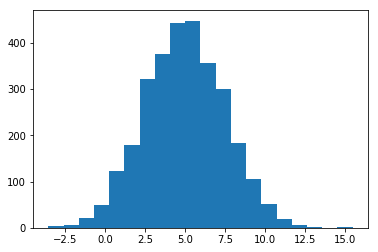

TensorShape([3000])

In [35]:
x = data_dist.sample(3000)
plt.hist(x,20)
plt.show()
x.shape

In [9]:
b = tfb.AffineScalar(shift=[3.0], scale=2.)
b.forward(4.0) #3 + 4*2=11

<tf.Tensor: id=176, shape=(1,), dtype=float32, numpy=array([11.], dtype=float32)>

In [10]:
# quite easy to interpret - multiplying by alpha causes a contraction in volume.
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=True, name="leaky_relu"):
        super(LeakyReLU, self).__init__(forward_min_event_ndims=0, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0.), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0.), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        #event_dims = self._event_dims_tensor(y)
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0.), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv)#, axis=event_dims)

In [11]:
b = LeakyReLU()
b.forward(4.0) #4.0
b.forward(-4.0) #-2.0 (alpha = 0.5)
b.forward(np.linspace(-2,2,dtype='float32')) #-1,...,2
b.forward(x)
b.inverse(x)
b.inverse_log_det_jacobian(-1.0,event_ndims=0) #0.693 (|log(0.5)|)
#b.inverse_log_det_jacobian(np.repeat(-1.0,10), event_ndims=0) #10 * 0.69
b.inverse_log_det_jacobian(x, event_ndims=0)

<tf.Tensor: id=264, shape=(), dtype=float32, numpy=34.657356>

### Using bijectors in eager mode

See e.g.
* https://stackoverflow.com/questions/53338975/use-and-modify-variables-in-tensorflow-bijectors 

In [12]:
# Creating the needed variables
K = 2
trainable_vars = []
for k in range(K):
    shift = tf.Variable(4+0.10*k, dtype='float32', name='shift')
    scale = tf.Variable(1.0+0.05*k,dtype='float32', name='scale')
    alpha = tf.Variable(1.0+0.1*k,dtype='float32', name='alpha')
    trainable_vars.append(shift)
    trainable_vars.append(scale)
    trainable_vars.append(alpha)

for v in trainable_vars:
    print(v)

<tf.Variable 'shift:0' shape=() dtype=float32, numpy=4.0>
<tf.Variable 'scale:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'alpha:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'shift:0' shape=() dtype=float32, numpy=4.1>
<tf.Variable 'scale:0' shape=() dtype=float32, numpy=1.05>
<tf.Variable 'alpha:0' shape=() dtype=float32, numpy=1.1>


In [13]:
def f(trainable_vars):
    bs = []
    for k in range(K):
        shift = trainable_vars[k*3 + 0]
        scale = trainable_vars[k*3 + 1]
        alpha = trainable_vars[k*3 + 2]
        bs.append(tfb.AffineScalar(shift=shift, scale=scale)) 
        bs.append(LeakyReLU(alpha=alpha))
    bijectors = tfb.Chain(bs)
    return tfd.TransformedDistribution(distribution=tfd.Normal(0,1), bijector=bijectors)

In [14]:
def loss_fun():
    dist = f(trainable_vars)
    loss = -tf.reduce_mean(dist.log_prob(x))
    return loss

In [15]:
optimizer = tf.optimizers.Adam(0.001)
for e in range(1000):
    with tf.GradientTape() as tape: 
        loss = loss_fun()
        if (e % 100 == 0):
            print(e, ' loss : ',loss.numpy(), [t.numpy() for t in trainable_vars])
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))
        #trainable_vars = trainable_vars_new

0  loss :  263.3287 [4.0, 1.0, 1.0, 4.1, 1.05, 1.1]
100  loss :  -102.063156 [3.9003067, 1.0915481, 0.8989665, 3.9998963, 1.1474582, 0.99821043]
200  loss :  -523.0706 [3.798798, 1.1714728, 0.79429305, 3.897887, 1.2410544, 0.8909516]
300  loss :  -1020.8425 [3.6910343, 1.2573684, 0.6853786, 3.7907104, 1.335598, 0.77716386]
400  loss :  -1633.4033 [3.57186, 1.3649212, 0.57044005, 3.6740472, 1.4361769, 0.6546335]
500  loss :  -2443.892 [3.433152, 1.5108305, 0.44729424, 3.5410144, 1.5503182, 0.5200873]
600  loss :  -3646.714 [3.2565114, 1.7171383, 0.31038904, 3.377588, 1.6940792, 0.36635447]
700  loss :  -6122.3135 [2.9813159, 2.0332615, 0.14496198, 3.140627, 1.923991, 0.17308053]
800  loss :  -10300.5 [2.5537143, 2.4413197, 0.21212631, 2.7092953, 2.3422167, 0.021127943]
900  loss :  -10697.51 [2.3303757, 2.5512924, 0.28731376, 2.414136, 2.5721247, 0.014939936]


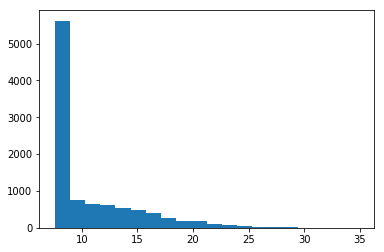

<tf.Tensor: id=548856, shape=(), dtype=float32, numpy=0.0>

In [16]:
d = f(trainable_vars)
sam = d.sample(10000)
plt.hist(sam,20)
plt.show()
d.prob(-1.0)

## Training in Keras

I am not sure but it seems that training in graph mode in TF 2.0 requires keras.

In [44]:
# class NVPLayer(tf.keras.layers.Layer):
class AffineFlow(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_layers = num_layers

    def call(self, *inputs):
        bijectors=[]
        bs = []
        for k in range(self.num_layers):
            shift = tf.Variable(4+0.10*k, dtype='float32', name='shift')
            scale = tf.Variable(1.0+0.05*k,dtype='float32', name='scale')
            alpha = tf.Variable(1.0+0.1*k,dtype='float32', name='alpha')
            bs.append(tfb.AffineScalar(shift=shift, scale=scale)) 
            bs.append(LeakyReLU(alpha=alpha))
        self.bijectors = tfb.Chain(bs)
        self.dist = tfd.TransformedDistribution(distribution=tfd.Normal(0,1), bijector=self.bijectors)
        self.loss = -tf.reduce_mean(self.dist.log_prob(*inputs)) # how else to do this?
        return self.bijectors.forward(*inputs)

model = AffineFlow(output_dim=2, num_layers=1)
_ = model(x)
model.trainable_variables, _

([], <tf.Tensor: id=1724343, shape=(3000,), dtype=float32, numpy=
 array([10.555374 ,  9.976794 , 10.432053 , ...,  9.416473 ,  9.023791 ,
         7.5250754], dtype=float32)>)

In [44]:
make_blobs

[]

### More Complex Flows

Taken from https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part2_modern.ipynb

In [151]:
from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
DTYPE=tf.float32
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 10000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
#noisy_moons = datasets.make_swiss_roll(n_samples)

X, _ = noisy_moons[:,0:2]
X = StandardScaler().fit_transform(X)
X = np.array(X, dtype='float32')
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)


TypeError: tuple indices must be integers or slices, not tuple

In [152]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

# class NVPLayer(tf.keras.layers.Layer):
class NVPLayer(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        self.MODEL = 'MAF'
        if MODEL == 'STACK':
            self.shift_and_log_scale_fn = tfb.real_nvp_default_template(
                hidden_layers=[2],
                activation=None, # linear
            )
        elif MODEL == 'MAF':
            self.shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(
                            hidden_layers=[16, 16])
        self.loss = None

    def call(self, *inputs):
        MODEL = self.MODEL
        if MODEL == 'STACK':
            self.bijector=tfb.RealNVP(
                    num_masked=self.num_masked,
                    shift_and_log_scale_fn=self.shift_and_log_scale_fn)
        elif self.MODEL == 'MAF':
            num_bijectors = 5
            bijectors=[]
            for i in range(num_bijectors):
            #     if MODEL == 'NVP':
            #         bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
                if MODEL == 'MAF':
                    self.shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(
                            hidden_layers=[16, 16])
                    bijectors.append(tfb.MaskedAutoregressiveFlow(
                        shift_and_log_scale_fn=self.shift_and_log_scale_fn))
                elif MODEL == 'IAF':
                    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
                        shift_and_log_scale_fn=self.shift_and_log_scale_fn)))
            #     if USE_BATCHNORM and i % 2 == 0:
            #         # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
            #         bijectors.append(BatchNorm(name='batch_norm%d' % i))
                bijectors.append(tfb.Permute(permutation=[1, 0]))
            # Discard the last Permute layer.
            self.bijector = tfb.Chain(list(reversed(bijectors[:-1])))
            
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=self.bijector)
          
        self.loss = -tf.reduce_mean(self.flow.log_prob(*inputs)) # how else to do this?
        return self.flow.bijector.forward(*inputs)

print(X.shape)
model = NVPLayer(output_dim=2, num_masked=1)
_ = model(X)
model.summary()

(10000, 3)


ValueError: Tensor's shape (10000, 2) is not compatible with supplied shape (10000, 3)

In [150]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(400):
    with tf.GradientTape() as tape:
        y = model(X)
        loss = model.loss
        if (i % 50 == 0):
            print(i, " ",loss.numpy())
    g = tape.gradient(loss, model.trainable_variables)
    l = optimizer.apply_gradients(zip(g, model.trainable_variables))

ValueError: Tensor's shape (10000, 2) is not compatible with supplied shape (10000, 3)

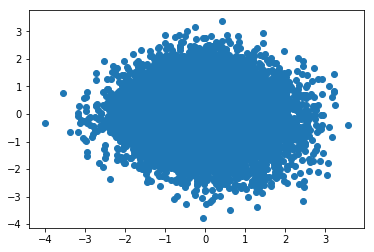

In [120]:
xm = model.flow.sample(10000)
plt.scatter(xm[:,0],xm[:,1])

In [75]:
xm.shape

TensorShape([10, 2])

In [56]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

# class NVPLayer(tf.keras.layers.Layer):
class NVPLayer(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        self.shift_and_log_scale_fn = tfb.real_nvp_default_template(
            hidden_layers=[2],
            activation=None, # linear
            )
        self.loss = None

    def call(self, *inputs):
        nvp = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
            bijector=tfb.RealNVP(
                num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn)
            )
        self.loss = tf.reduce_mean(nvp.log_prob(*inputs)) # how else to do this?
        return nvp.bijector.forward(*inputs)

x3 = (np.random.randn(100, 3) * np.array([1, 3, 5]) + np.array([-3, -10, 4])).astype(np.float32)
model = NVPLayer(output_dim=3, num_masked=1)
_ = model(x3)
model.trainable_variables
model.summary()

Model: "nvp_layer_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(1000):
    with tf.GradientTape() as tape:
        y = model(x)
        loss = model.loss
        if (i % 100 == 0):
            print(loss)
    g = tape.gradient(loss, model.trainable_variables)
    l = optimizer.apply_gradients(zip(g, model.trainable_variables))

ValueError: Trying to share variable real_nvp_default_template_15/dense_1/kernel, but specified shape (2, 2) and found shape (2, 4).

originally defined at:
  File "<ipython-input-56-015148ce13b8>", line 34, in <module>
    model = NVPLayer(output_dim=3, num_masked=1)
  File "<ipython-input-56-015148ce13b8>", line 19, in __init__
    activation=None, # linear
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/bijectors/real_nvp.py", line 305, in real_nvp_default_template
    return tf.compat.v1.make_template("real_nvp_default_template", _fn)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/template.py", line 154, in make_template
    **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/template.py", line 217, in make_template_internal
    create_graph_function=create_graph_function_)


In [33]:
_ = model(x)
model.trainable_variables

[<tf.Variable 'real_nvp_default_template_4/dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_4/dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 0.21195447, -0.8513397 ]], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_4/dense_1/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_4/dense_1/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 0.83960485,  0.8042946 , -0.16946769, -0.83414316],
        [-0.79918337, -0.87692356,  0.5342984 , -0.88909316]],
       dtype=float32)>]

In [21]:
x3 = (np.random.randn(100, 3) * np.array([1, 3, 5]) + np.array([-3, -10, 4])).astype(np.float32)
z0 = layer(x).numpy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(1000):
    with tf.GradientTape() as tape:
        y = model(x)
        loss = - layer.loss
        if (i % 100 == 0):
            print(loss)
    g = tape.gradient(loss, model.trainable_variables)
    l = optimizer.apply_gradients(zip(g, model.trainable_variables))

z1 = layer(x).numpy()

print(pd.DataFrame(z0).describe())
print(pd.DataFrame(z1).describe())

tf.Tensor(107.39296, shape=(), dtype=float32)
tf.Tensor(13.447729, shape=(), dtype=float32)
tf.Tensor(12.831918, shape=(), dtype=float32)
tf.Tensor(12.648834, shape=(), dtype=float32)
tf.Tensor(12.50915, shape=(), dtype=float32)
tf.Tensor(12.393262, shape=(), dtype=float32)
tf.Tensor(12.281681, shape=(), dtype=float32)
tf.Tensor(12.157948, shape=(), dtype=float32)
tf.Tensor(12.006743, shape=(), dtype=float32)
tf.Tensor(11.802393, shape=(), dtype=float32)
                0           1           2
count  100.000000  100.000000  100.000000
mean    -2.923969   -8.289864    4.521695
std      0.901834    2.384400    5.508754
min     -5.081929  -14.593492   -9.294298
25%     -3.545624  -10.029204    0.324297
50%     -3.029405   -8.202483    4.307903
75%     -2.392846   -6.664856    8.687210
max     -0.426640   -2.390517   17.224598
                0           1           2
count  100.000000  100.000000  100.000000
mean    -2.923969  -48.655521   31.039061
std      0.901834   14.365493   33.03

In [22]:
layer.trainable_variables

[<tf.Variable 'real_nvp_default_template_2/dense/bias:0' shape=(2,) dtype=float32, numpy=array([0.39575386, 0.91417325], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_2/dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[-0.16574961, -0.35506135]], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_2/dense_1/bias:0' shape=(4,) dtype=float32, numpy=array([-1.1758118 ,  0.8968756 ,  0.48219788,  0.41847873], dtype=float32)>,
 <tf.Variable 'real_nvp_default_template_2/dense_1/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[-0.9103618 , -0.404004  , -0.26161638,  0.54230016],
        [-3.1074097 ,  2.1046715 ,  0.5939846 ,  0.43404305]],
       dtype=float32)>]

(-2, 2)

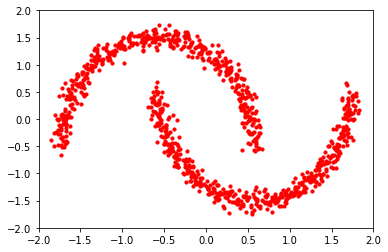

In [46]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
DTYPE=tf.float32
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, _ = noisy_moons
X = StandardScaler().fit_transform(X)
X = np.array(X, dtype='float32')
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

How to train?
https://stackoverflow.com/questions/57261612/better-way-of-building-realnvp-layer-in-tensorflow-2-0

In [4]:
num_bijectors = 3
MODEL = 'MAF'
bijectors=[]
for i in range(num_bijectors):
#     if MODEL == 'NVP':
#         bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    if MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
#     if USE_BATCHNORM and i % 2 == 0:
#         # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
#         bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

# class NVPLayer(tf.keras.layers.Layer):
class NVPLayer(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        bijectors=[]
        for i in range(num_bijectors):
        #     if MODEL == 'NVP':
        #         bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
            if MODEL == 'MAF':
                bijectors.append(tfb.MaskedAutoregressiveFlow(
                    shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                        hidden_layers=[512, 512])))
            elif MODEL == 'IAF':
                bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
                    shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                        hidden_layers=[512, 512]))))
        #     if USE_BATCHNORM and i % 2 == 0:
        #         # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        #         bijectors.append(BatchNorm(name='batch_norm%d' % i))
            bijectors.append(tfb.Permute(permutation=[1, 0]))
        # Discard the last Permute layer.
        flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        self.loss = None

    def call(self, *inputs):
        nvp = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
            bijector=tfb.RealNVP(
                num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn)
            )
        self.loss = tf.reduce_mean(nvp.log_prob(*inputs)) # how else to do this?
        return nvp.bijector.forward(*inputs)

layer = NVPLayer(output_dim=2, num_masked=1)

NameError: name 'num_bijectors' is not defined

In [22]:
layer(X[0:10])

InvalidArgumentError: Incompatible shapes: [10,2] vs. [3] [Op:Sub] name: nvp_layer_2/MultivariateNormalDiag/log_prob/affine_linear_operator/inverse/sub/

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(1000):
    with tf.GradientTape() as tape:
        y = layer(x)
        loss = - layer.loss
        print(loss)
    g = tape.gradient(loss, layer.trainable_variables)
    l = optimizer.apply_gradients(zip(g, layer.trainable_variables))

z1 = layer(x).numpy()

W0903 22:19:42.521914 140599811327744 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/bijectors/real_nvp.py:293: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


tf.Tensor(56832380.0, shape=(), dtype=float32)
tf.Tensor(35077970.0, shape=(), dtype=float32)
tf.Tensor(22218334.0, shape=(), dtype=float32)
tf.Tensor(14539017.0, shape=(), dtype=float32)
tf.Tensor(9851806.0, shape=(), dtype=float32)
tf.Tensor(6909270.5, shape=(), dtype=float32)
tf.Tensor(5005138.5, shape=(), dtype=float32)
tf.Tensor(3735379.0, shape=(), dtype=float32)
tf.Tensor(2864121.5, shape=(), dtype=float32)
tf.Tensor(2250278.2, shape=(), dtype=float32)
tf.Tensor(1807186.2, shape=(), dtype=float32)
tf.Tensor(1480236.0, shape=(), dtype=float32)
tf.Tensor(1234122.4, shape=(), dtype=float32)
tf.Tensor(1045488.2, shape=(), dtype=float32)
tf.Tensor(898530.5, shape=(), dtype=float32)
tf.Tensor(782334.94, shape=(), dtype=float32)
tf.Tensor(689224.25, shape=(), dtype=float32)
tf.Tensor(613698.25, shape=(), dtype=float32)
tf.Tensor(551754.75, shape=(), dtype=float32)
tf.Tensor(500437.38, shape=(), dtype=float32)
tf.Tensor(457530.9, shape=(), dtype=float32)
tf.Tensor(421353.03, shape=(), d

tf.Tensor(76359.16, shape=(), dtype=float32)
tf.Tensor(76003.42, shape=(), dtype=float32)
tf.Tensor(75650.31, shape=(), dtype=float32)
tf.Tensor(75299.43, shape=(), dtype=float32)
tf.Tensor(74951.266, shape=(), dtype=float32)
tf.Tensor(74605.445, shape=(), dtype=float32)
tf.Tensor(74261.95, shape=(), dtype=float32)
tf.Tensor(73920.88, shape=(), dtype=float32)
tf.Tensor(73582.2, shape=(), dtype=float32)
tf.Tensor(73245.88, shape=(), dtype=float32)
tf.Tensor(72911.8, shape=(), dtype=float32)
tf.Tensor(72580.14, shape=(), dtype=float32)
tf.Tensor(72250.66, shape=(), dtype=float32)
tf.Tensor(71923.53, shape=(), dtype=float32)
tf.Tensor(71598.65, shape=(), dtype=float32)
tf.Tensor(71275.94, shape=(), dtype=float32)
tf.Tensor(70955.49, shape=(), dtype=float32)
tf.Tensor(70637.266, shape=(), dtype=float32)
tf.Tensor(70321.17, shape=(), dtype=float32)
tf.Tensor(70007.24, shape=(), dtype=float32)
tf.Tensor(69695.48, shape=(), dtype=float32)
tf.Tensor(69385.74, shape=(), dtype=float32)
tf.Tensor

tf.Tensor(37603.344, shape=(), dtype=float32)
tf.Tensor(37486.785, shape=(), dtype=float32)
tf.Tensor(37370.797, shape=(), dtype=float32)
tf.Tensor(37255.42, shape=(), dtype=float32)
tf.Tensor(37140.582, shape=(), dtype=float32)
tf.Tensor(37026.33, shape=(), dtype=float32)
tf.Tensor(36912.617, shape=(), dtype=float32)
tf.Tensor(36799.523, shape=(), dtype=float32)
tf.Tensor(36686.926, shape=(), dtype=float32)
tf.Tensor(36574.92, shape=(), dtype=float32)
tf.Tensor(36463.484, shape=(), dtype=float32)
tf.Tensor(36352.555, shape=(), dtype=float32)
tf.Tensor(36242.203, shape=(), dtype=float32)
tf.Tensor(36132.348, shape=(), dtype=float32)
tf.Tensor(36023.06, shape=(), dtype=float32)
tf.Tensor(35914.3, shape=(), dtype=float32)
tf.Tensor(35806.117, shape=(), dtype=float32)
tf.Tensor(35698.414, shape=(), dtype=float32)
tf.Tensor(35591.25, shape=(), dtype=float32)
tf.Tensor(35484.598, shape=(), dtype=float32)
tf.Tensor(35378.445, shape=(), dtype=float32)
tf.Tensor(35272.824, shape=(), dtype=floa

tf.Tensor(22998.81, shape=(), dtype=float32)
tf.Tensor(22946.26, shape=(), dtype=float32)
tf.Tensor(22893.885, shape=(), dtype=float32)
tf.Tensor(22841.717, shape=(), dtype=float32)
tf.Tensor(22789.76, shape=(), dtype=float32)
tf.Tensor(22737.963, shape=(), dtype=float32)
tf.Tensor(22686.355, shape=(), dtype=float32)
tf.Tensor(22634.965, shape=(), dtype=float32)
tf.Tensor(22583.727, shape=(), dtype=float32)
tf.Tensor(22532.697, shape=(), dtype=float32)
tf.Tensor(22481.852, shape=(), dtype=float32)
tf.Tensor(22431.215, shape=(), dtype=float32)
tf.Tensor(22380.727, shape=(), dtype=float32)
tf.Tensor(22330.445, shape=(), dtype=float32)
tf.Tensor(22280.346, shape=(), dtype=float32)
tf.Tensor(22230.42, shape=(), dtype=float32)
tf.Tensor(22180.682, shape=(), dtype=float32)
tf.Tensor(22131.113, shape=(), dtype=float32)
tf.Tensor(22081.742, shape=(), dtype=float32)
tf.Tensor(22032.535, shape=(), dtype=float32)
tf.Tensor(21983.506, shape=(), dtype=float32)
tf.Tensor(21934.658, shape=(), dtype=f

tf.Tensor(15845.735, shape=(), dtype=float32)
tf.Tensor(15816.9375, shape=(), dtype=float32)
tf.Tensor(15788.236, shape=(), dtype=float32)
tf.Tensor(15759.615, shape=(), dtype=float32)
tf.Tensor(15731.074, shape=(), dtype=float32)
tf.Tensor(15702.616, shape=(), dtype=float32)
tf.Tensor(15674.233, shape=(), dtype=float32)
tf.Tensor(15645.94, shape=(), dtype=float32)
tf.Tensor(15617.728, shape=(), dtype=float32)
tf.Tensor(15589.603, shape=(), dtype=float32)
tf.Tensor(15561.546, shape=(), dtype=float32)
tf.Tensor(15533.588, shape=(), dtype=float32)
tf.Tensor(15505.715, shape=(), dtype=float32)
tf.Tensor(15477.896, shape=(), dtype=float32)
tf.Tensor(15450.166, shape=(), dtype=float32)
tf.Tensor(15422.517, shape=(), dtype=float32)
tf.Tensor(15394.963, shape=(), dtype=float32)
tf.Tensor(15367.463, shape=(), dtype=float32)
tf.Tensor(15340.059, shape=(), dtype=float32)
tf.Tensor(15312.733, shape=(), dtype=float32)
tf.Tensor(15285.477, shape=(), dtype=float32)
tf.Tensor(15258.303, shape=(), dty

tf.Tensor(11751.361, shape=(), dtype=float32)
tf.Tensor(11733.494, shape=(), dtype=float32)
tf.Tensor(11715.6875, shape=(), dtype=float32)
tf.Tensor(11697.915, shape=(), dtype=float32)
tf.Tensor(11680.188, shape=(), dtype=float32)
tf.Tensor(11662.513, shape=(), dtype=float32)
tf.Tensor(11644.865, shape=(), dtype=float32)
tf.Tensor(11627.264, shape=(), dtype=float32)
tf.Tensor(11609.714, shape=(), dtype=float32)
tf.Tensor(11592.2, shape=(), dtype=float32)
tf.Tensor(11574.723, shape=(), dtype=float32)
tf.Tensor(11557.293, shape=(), dtype=float32)
tf.Tensor(11539.903, shape=(), dtype=float32)
tf.Tensor(11522.562, shape=(), dtype=float32)
tf.Tensor(11505.253, shape=(), dtype=float32)
tf.Tensor(11487.99, shape=(), dtype=float32)
tf.Tensor(11470.768, shape=(), dtype=float32)
tf.Tensor(11453.582, shape=(), dtype=float32)
tf.Tensor(11436.446, shape=(), dtype=float32)
tf.Tensor(11419.336, shape=(), dtype=float32)
tf.Tensor(11402.28, shape=(), dtype=float32)
tf.Tensor(11385.255, shape=(), dtype=

In [6]:
flow_bijector(X[0:3])

<tf.Tensor: id=940, shape=(3, 2), dtype=float32, numpy=
array([[-0.5930148 ,  0.28108868],
       [ 0.544012  , -1.4328741 ],
       [ 0.46123058, -1.2653836 ]], dtype=float32)>

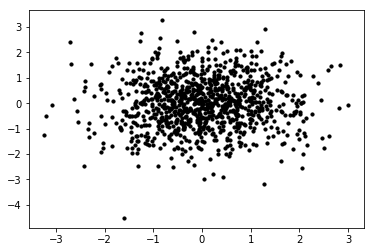

In [7]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))
#base_dist = tfd.Normal(0,1,DTYPE)
z = base_dist.sample(1000)
plt.scatter(z[:, 0], z[:, 1], s=10, color='black')

In [8]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

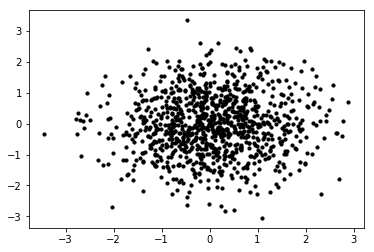

In [15]:
x = dist.sample(1000)
plt.scatter(x[:, 0], x[:, 1], s=10, color='black')

In [16]:
def loss():
    return -tf.reduce_mean(dist.log_prob(X))
loss()

<tf.Tensor: id=6244, shape=(), dtype=float32, numpy=2.8639553>

In [17]:
train_op = tf.optimizers.Adam(1e-4).minimize(loss)

TypeError: minimize() missing 1 required positional argument: 'var_list'

In [28]:
dist.log_prob(X)

ValueError: Trying to share variable masked_autoregressive_default_template_8/dense/kernel, but specified dtype float32 and found dtype float64.

originally defined at:
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-1d3d60a38b41>", line 10, in <module>
    hidden_layers=[512, 512])))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py", line 528, in masked_autoregressive_default_template
    return tf.compat.v1.make_template(name, _fn)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/template.py", line 154, in make_template
    **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/template.py", line 217, in make_template_internal
    create_graph_function=create_graph_function_)
